<a href="https://colab.research.google.com/github/Dharani-Gurumoorthy/Brain-Tumor-Detection/blob/main/brain_tumor_detectionfinalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Import needed modules

In [ ]:
!pip install opendatasets
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dharanigurumoorthy
Your Kaggle Key: ··········


100%|██████████| 15.1M/15.1M [00:00<00:00, 165MB/s]

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

 **Read data and store it in dataframe**

In [ ]:
# Generate data paths with labels
data_dir = '/content/brain-mri-images-for-brain-tumor-detection'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

,filepaths,labels
0,/content/brain-mri-images-for-brain-tumor-dete...,yes
1,/content/brain-mri-images-for-brain-tumor-dete...,yes
2,/content/brain-mri-images-for-brain-tumor-dete...,yes
3,/content/brain-mri-images-for-brain-tumor-dete...,yes
4,/content/brain-mri-images-for-brain-tumor-dete...,yes
...,...,...
250,/content/brain-mri-images-for-brain-tumor-dete...,no
251,/content/brain-mri-images-for-brain-tumor-dete...,no
252,/content/brain-mri-images-for-brain-tumor-dete...,no
253,/content/brain-mri-images-for-brain-tumor-dete...,brain_tumor_dataset


### **Split data into train, valid, and test**

In [ ]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

### **Create image data generator**

> Indented block



In [ ]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


### **Show sample from train data**

1.   List item
2.   List item



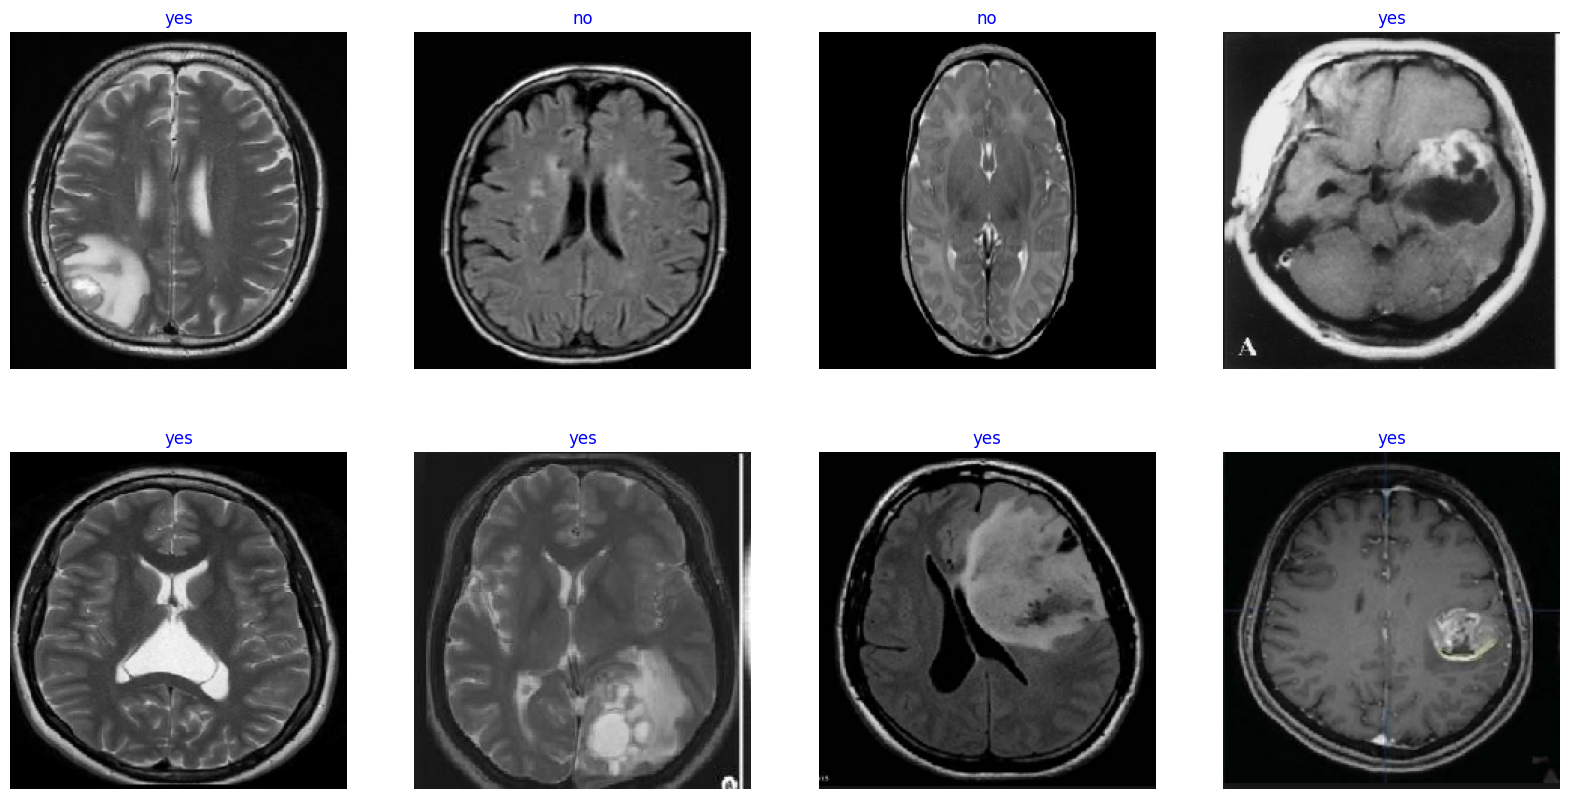

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()



```
# This is formatted as code
```

# **Model Structure**

#### **Generic Model Creation**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",
                                                               input_shape= img_shape, pooling= 'max')


model_effnet = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model_effnet.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model_effnet.summary()

43941136/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

####**Train model**

In [ ]:
epochs = 30   # number of all epochs in training

history = model_effnet.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/30
26/26 [==============================] - 90s 336ms/step - loss: 8.4232 - accuracy: 0.6832 - val_loss: 8.7544 - val_accuracy: 0.7255
Epoch 2/30
26/26 [==============================] - 4s 145ms/step - loss: 7.3885 - accuracy: 0.8168 - val_loss: 7.9390 - val_accuracy: 0.8235
Epoch 3/30
26/26 [==============================] - 4s 145ms/step - loss: 6.8493 - accuracy: 0.8515 - val_loss: 7.5009 - val_accuracy: 0.8431
Epoch 4/30
26/26 [==============================] - 4s 156ms/step - loss: 6.2993 - accuracy: 0.9208 - val_loss: 6.7630 - val_accuracy: 0.8039
Epoch 5/30
26/26 [==============================] - 5s 188ms/step - loss: 5.9935 - accuracy: 0.9307 - val_loss: 6.4048 - val_accuracy: 0.8627
Epoch 6/30
26/26 [==============================] - 7s 273ms/step - loss: 5.6320 - accuracy: 0.9406 - val_loss: 5.7662 - val_accuracy: 0.9216
Epoch 7/30
26/26 [==============================] - 5s 190ms/step - loss: 5.4937 - accuracy: 0.9158 - val_loss: 5.5681 - val_accuracy: 0.8431
Epoch

#### **Display model performance**

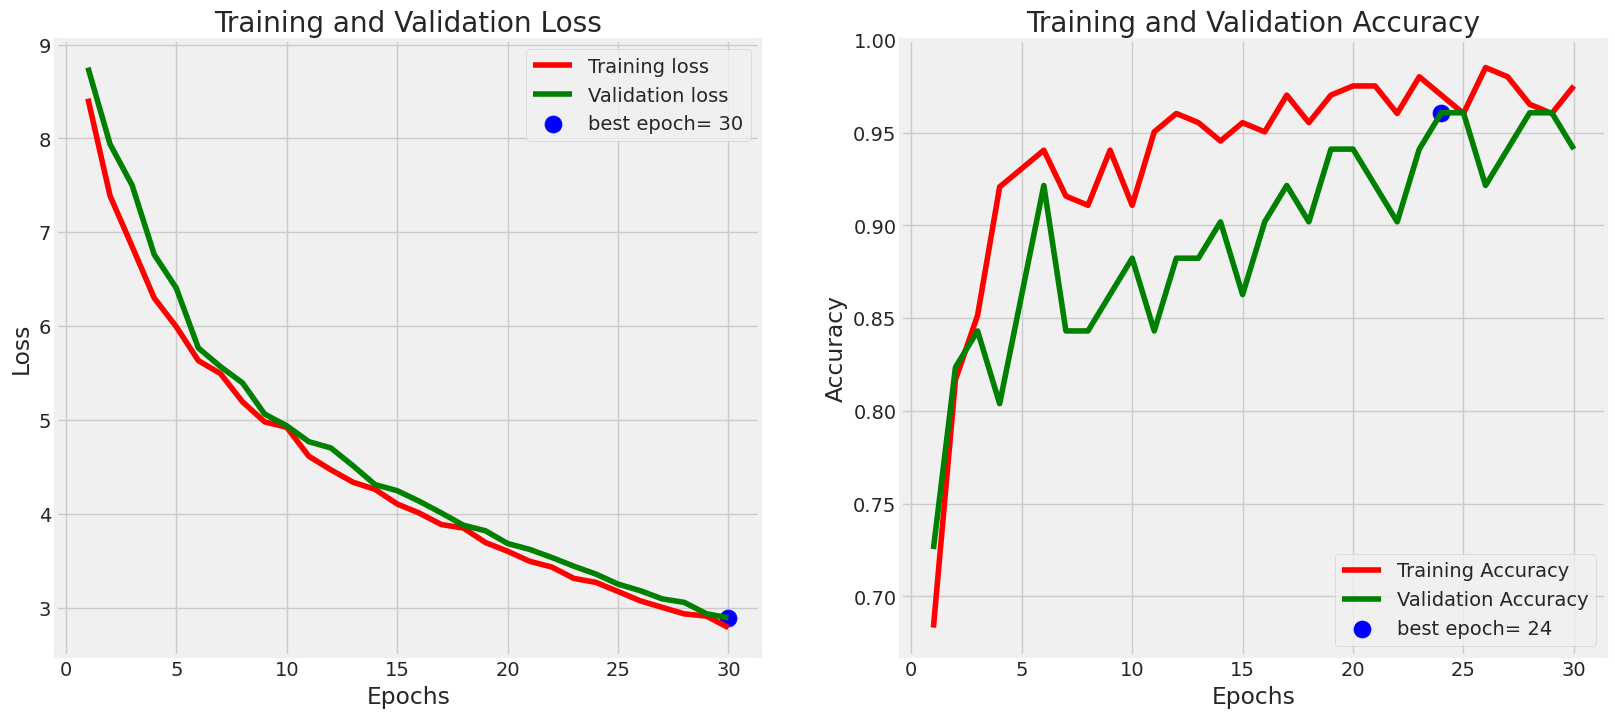

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [ ]:
train_score = model_effnet.evaluate(train_gen, verbose= 1)
test_score = model_effnet.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 0s 36ms/step - loss: 2.8907 - accuracy: 0.9412
Train Loss:  2.7470767498016357
Train Accuracy:  1.0
--------------------
Test Loss:  2.8906657695770264
Test Accuracy:  0.9411764740943909


# **Get Predictions**

In [ ]:
preds = model_effnet.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **Confusion Matrics and Classification Report**

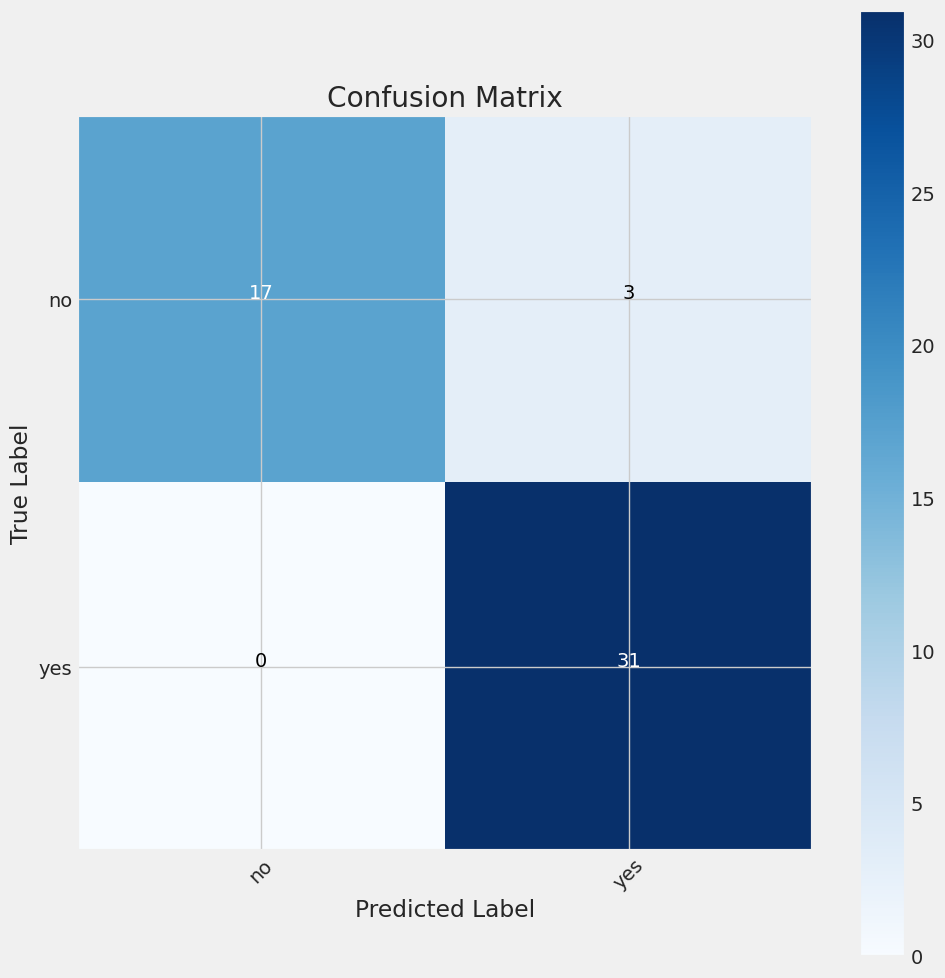

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       1.00      0.85      0.92        20
         yes       0.91      1.00      0.95        31

    accuracy                           0.94        51
   macro avg       0.96      0.93      0.94        51
weighted avg       0.95      0.94      0.94        51



#### **Save model**

In [ ]:
#Save the model
model_effnet.save('Model_effnet.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('Model_effnet.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = r'/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y104.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 4s 4s/step
yes


In [ ]:
from tensorflow.keras.applications import ResNet50

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model using ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
# Freeze the base model layers
base_model.trainable = False

model_resnet50 = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model_resnet50.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_resnet50.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24120962 (92.01 MB)
Trainable params: 529

In [ ]:
epochs = 30   # number of all epochs in training

history = model_resnet50.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/30
26/26 [==============================] - 9s 159ms/step - loss: 8.4376 - accuracy: 0.7525 - val_loss: 10.0606 - val_accuracy: 0.7843
Epoch 2/30
26/26 [==============================] - 1s 45ms/step - loss: 7.3982 - accuracy: 0.8812 - val_loss: 7.9323 - val_accuracy: 0.8235
Epoch 3/30
26/26 [==============================] - 1s 46ms/step - loss: 6.6364 - accuracy: 0.9455 - val_loss: 6.9249 - val_accuracy: 0.8627
Epoch 4/30
26/26 [==============================] - 1s 46ms/step - loss: 6.1741 - accuracy: 0.9356 - val_loss: 6.3560 - val_accuracy: 0.8824
Epoch 5/30
26/26 [==============================] - 1s 45ms/step - loss: 5.8258 - accuracy: 0.9752 - val_loss: 5.9064 - val_accuracy: 0.9412
Epoch 6/30
26/26 [==============================] - 1s 45ms/step - loss: 5.4882 - accuracy: 0.9752 - val_loss: 5.5908 - val_accuracy: 0.9412
Epoch 7/30
26/26 [==============================] - 1s 45ms/step - loss: 5.2289 - accuracy: 0.9851 - val_loss: 5.3194 - val_accuracy: 0.9412
Epoch 8/30


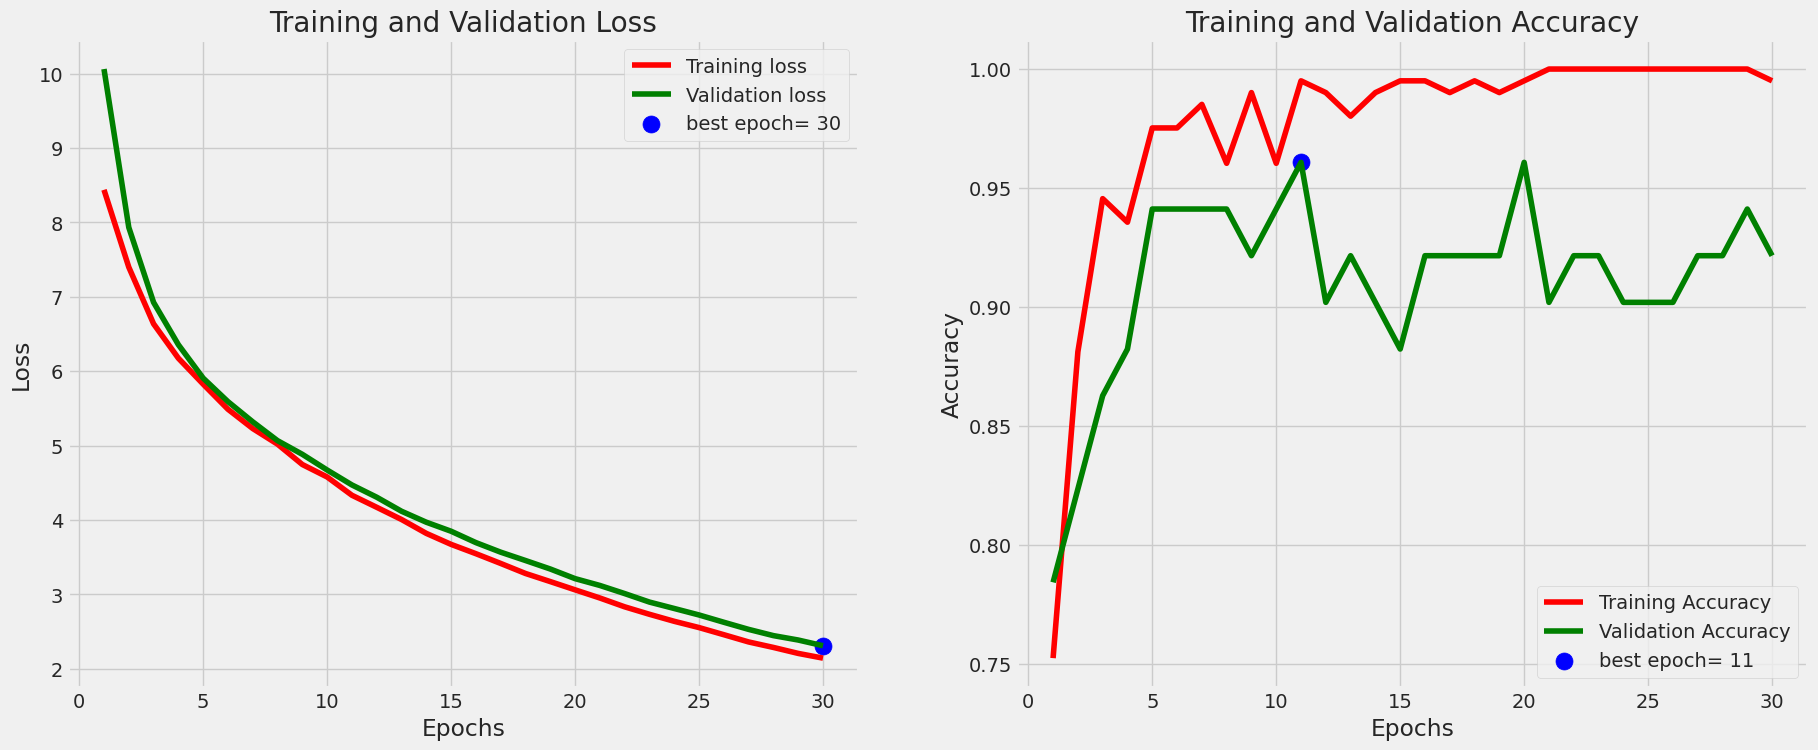

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model_resnet50.evaluate(train_gen, verbose= 1)
test_score = model_resnet50.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 0s 33ms/step - loss: 2.3104 - accuracy: 0.9216
Train Loss:  2.068162441253662
Train Accuracy:  1.0
--------------------
Test Loss:  2.310401201248169
Test Accuracy:  0.9215686321258545


In [ ]:
preds = model_resnet50.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

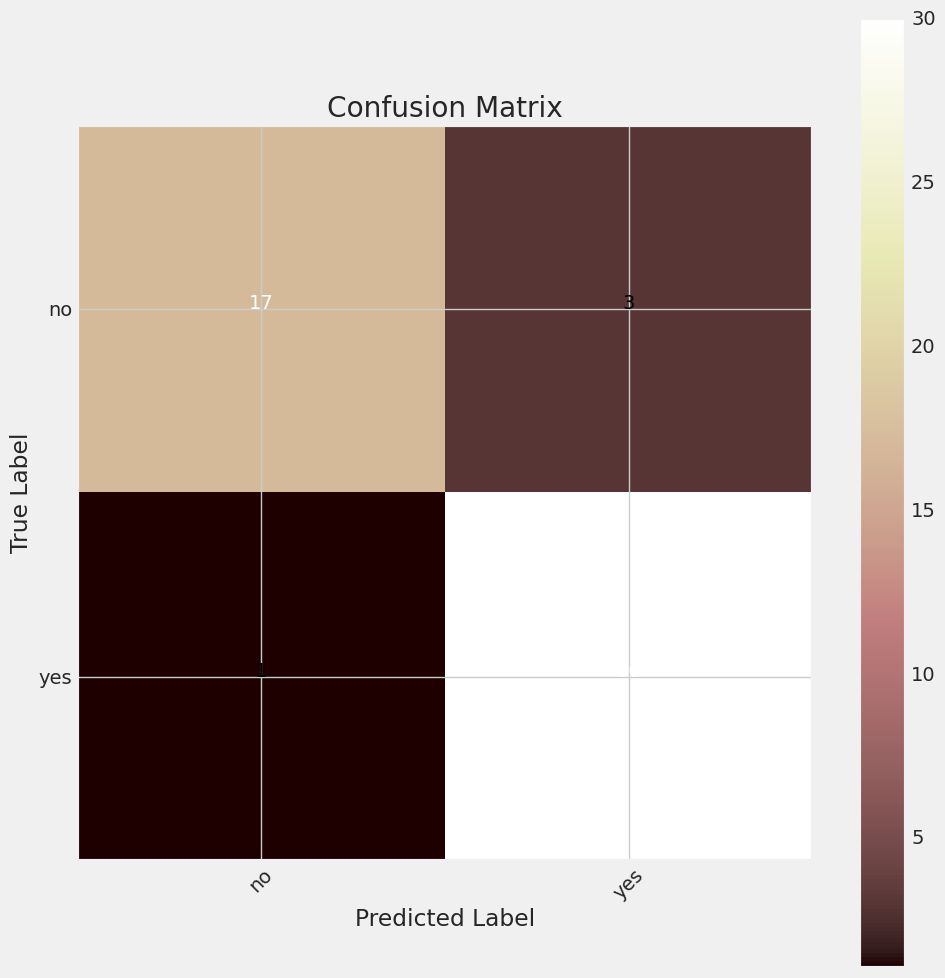

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.pink)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       0.94      0.85      0.89        20
         yes       0.91      0.97      0.94        31

    accuracy                           0.92        51
   macro avg       0.93      0.91      0.92        51
weighted avg       0.92      0.92      0.92        51



In [ ]:
#Save the model
model_resnet50.save('Model_resnet50.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('Model_resnet50.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = r'/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y104.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 2s 2s/step
yes


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adamax

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model_cnn = Sequential([
    # Convolutional layers
    Conv2D(64, (3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the feature maps
    Flatten(),

    # Fully connected layers with regularization and dropout
    Dense(256, kernel_regularizer=l2(0.016), activity_regularizer=l1(0.006), bias_regularizer=l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),

    # Output layer
    Dense(class_count, activation='softmax')
])

model_cnn.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 256)      

In [ ]:
epochs = 30   # number of all epochs in training

history = model_cnn.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/30
26/26 [==============================] - 9s 80ms/step - loss: 32.5488 - accuracy: 0.6683 - val_loss: 6.0015 - val_accuracy: 0.8039
Epoch 2/30
26/26 [==============================] - 1s 43ms/step - loss: 5.8298 - accuracy: 0.6832 - val_loss: 5.6011 - val_accuracy: 0.7843
Epoch 3/30
26/26 [==============================] - 1s 43ms/step - loss: 5.4527 - accuracy: 0.7426 - val_loss: 5.2380 - val_accuracy: 0.8431
Epoch 4/30
26/26 [==============================] - 1s 42ms/step - loss: 5.1187 - accuracy: 0.7822 - val_loss: 5.0247 - val_accuracy: 0.8235
Epoch 5/30
26/26 [==============================] - 1s 50ms/step - loss: 4.9315 - accuracy: 0.7822 - val_loss: 4.8118 - val_accuracy: 0.8039
Epoch 6/30
26/26 [==============================] - 1s 42ms/step - loss: 4.7080 - accuracy: 0.8020 - val_loss: 4.6459 - val_accuracy: 0.8235
Epoch 7/30
26/26 [==============================] - 1s 43ms/step - loss: 4.5327 - accuracy: 0.8267 - val_loss: 4.4957 - val_accuracy: 0.8039
Epoch 8/30
2

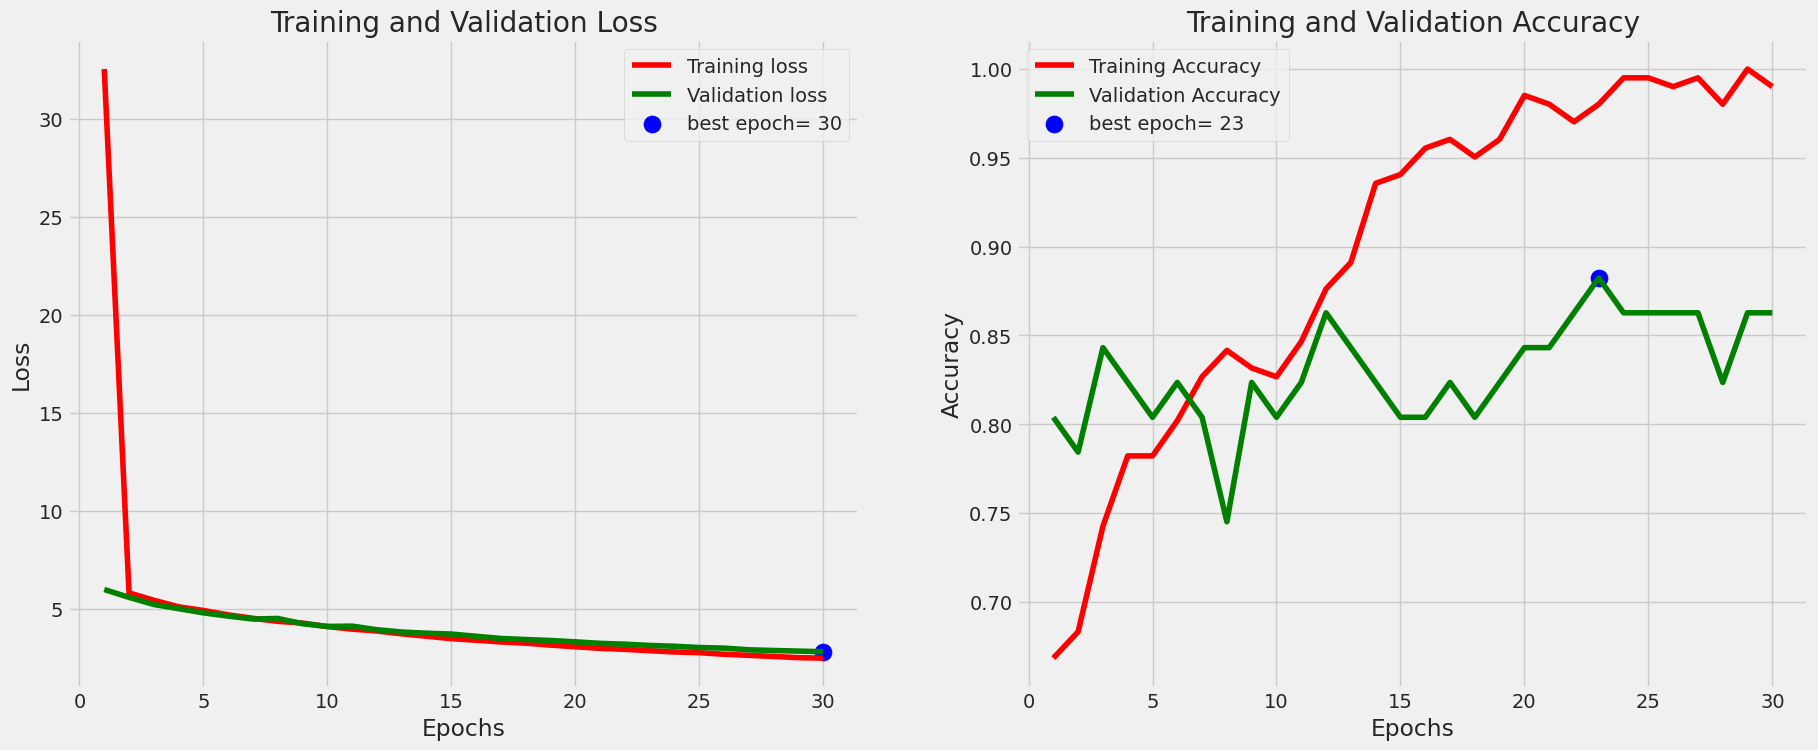

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model_cnn.evaluate(train_gen, verbose= 1)
test_score = model_cnn.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 0s 26ms/step - loss: 2.8270 - accuracy: 0.8627
Train Loss:  2.422293186187744
Train Accuracy:  1.0
--------------------
Test Loss:  2.827022075653076
Test Accuracy:  0.8627451062202454


In [ ]:
preds = model_cnn.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

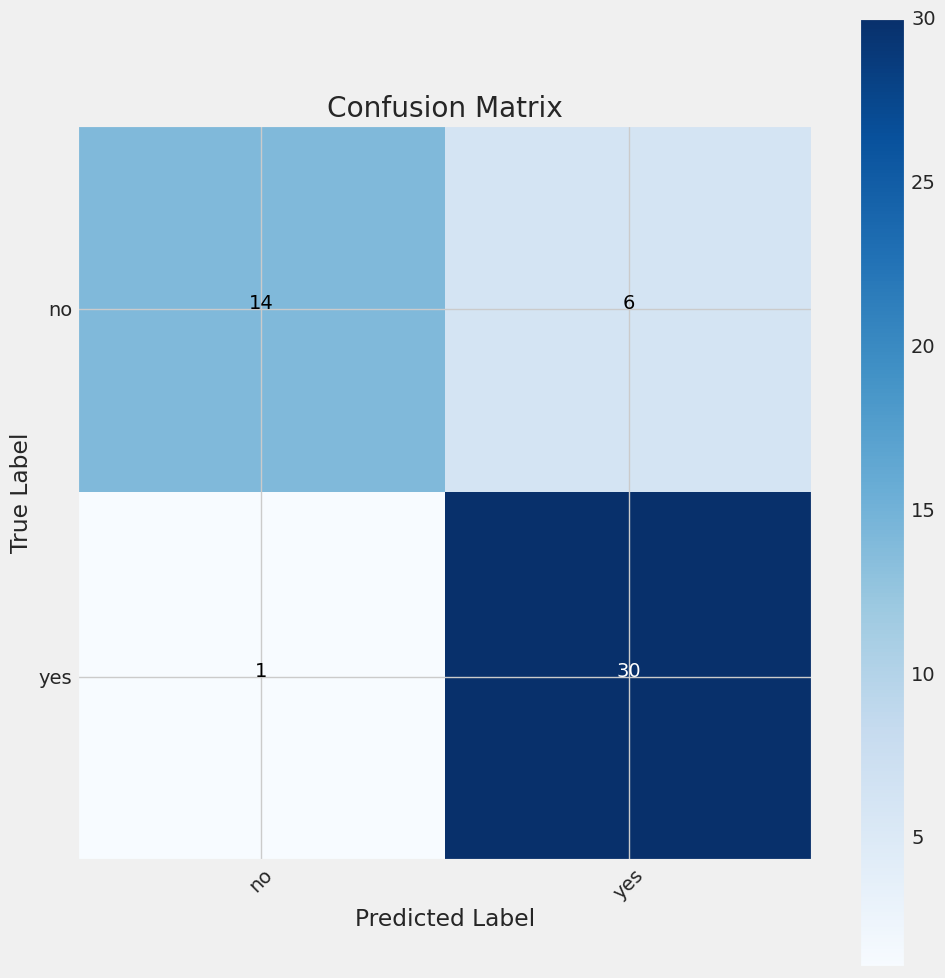

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       0.93      0.70      0.80        20
         yes       0.83      0.97      0.90        31

    accuracy                           0.86        51
   macro avg       0.88      0.83      0.85        51
weighted avg       0.87      0.86      0.86        51



In [ ]:
#Save the model
model_cnn.save('Model_cnn.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('Model_cnn.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = r'/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y104.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 362ms/step
yes


In [ ]:
from tensorflow.keras.applications import VGG16

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model using VGG16
base_model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
# Freeze the base model layers
base_model_vgg.trainable = False

model_vgg = Sequential([
    base_model_vgg,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model_vgg.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 14848578 (56.64 MB)
Trainable params: 132

In [ ]:
epochs = 30   # number of all epochs in training

history = model_vgg.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/30
26/26 [==============================] - 6s 134ms/step - loss: 6.6156 - accuracy: 0.6485 - val_loss: 9.6290 - val_accuracy: 0.6078
Epoch 2/30
26/26 [==============================] - 2s 60ms/step - loss: 5.8487 - accuracy: 0.8267 - val_loss: 6.9667 - val_accuracy: 0.6275
Epoch 3/30
26/26 [==============================] - 2s 73ms/step - loss: 5.4209 - accuracy: 0.8317 - val_loss: 6.0337 - val_accuracy: 0.7255
Epoch 4/30
26/26 [==============================] - 1s 57ms/step - loss: 5.0320 - accuracy: 0.9208 - val_loss: 5.4436 - val_accuracy: 0.7843
Epoch 5/30
26/26 [==============================] - 2s 58ms/step - loss: 4.7942 - accuracy: 0.9010 - val_loss: 4.9929 - val_accuracy: 0.8627
Epoch 6/30
26/26 [==============================] - 2s 58ms/step - loss: 4.5221 - accuracy: 0.9604 - val_loss: 4.6789 - val_accuracy: 0.8627
Epoch 7/30
26/26 [==============================] - 2s 58ms/step - loss: 4.3101 - accuracy: 0.9455 - val_loss: 4.4212 - val_accuracy: 0.8431
Epoch 8/30
2

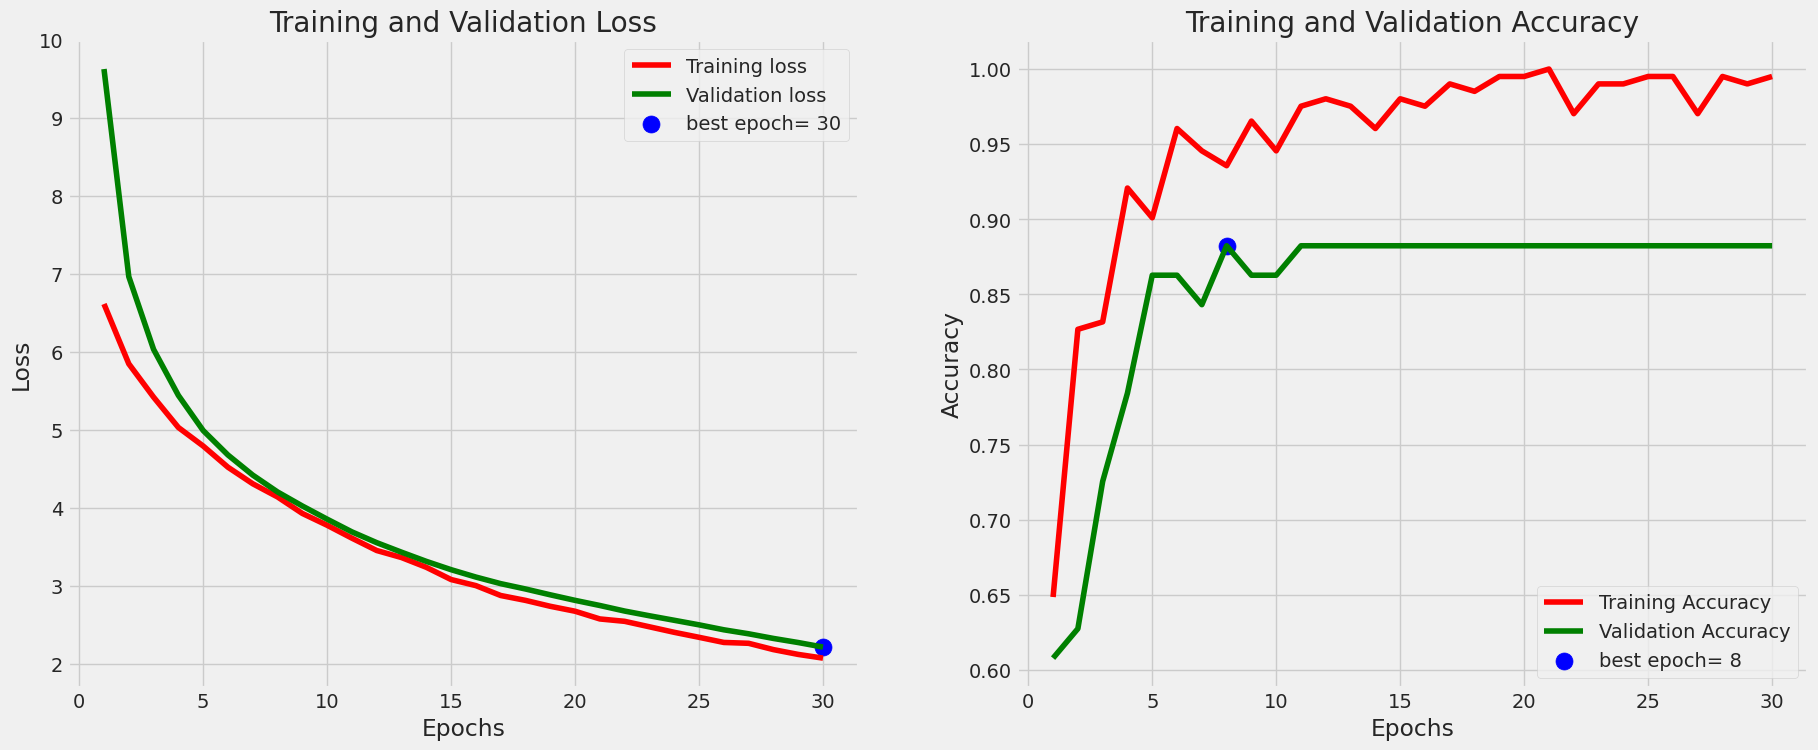

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
train_score = model_vgg.evaluate(train_gen, verbose= 1)
test_score = model_vgg.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 0s 42ms/step - loss: 2.2154 - accuracy: 0.8824
Train Loss:  2.006013870239258
Train Accuracy:  1.0
--------------------
Test Loss:  2.2154457569122314
Test Accuracy:  0.8823529481887817


In [ ]:
preds = model_vgg.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

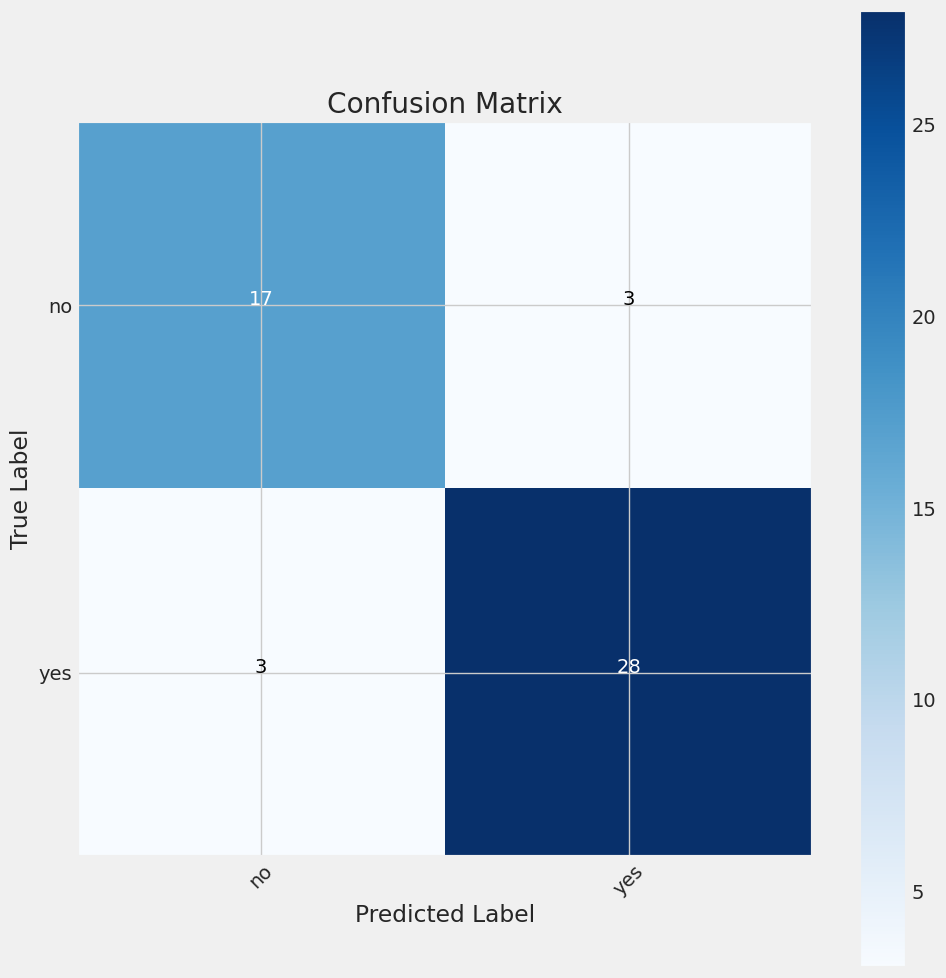

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       0.85      0.85      0.85        20
         yes       0.90      0.90      0.90        31

    accuracy                           0.88        51
   macro avg       0.88      0.88      0.88        51
weighted avg       0.88      0.88      0.88        51



In [ ]:
#Save the model
model_vgg.save('Model_vgg.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('Model_vgg.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = r'/content/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y104.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 1s 667ms/step
yes


7/7 [==============================] - 0s 17ms/step
            Model  Accuracy  Precision    Recall  F1-Score
0  EfficientNet80  0.941176   0.955882  0.925000  0.936383
1           VGG16  0.882353   0.876613  0.876613  0.876613
2        Resnet50  0.921569   0.926768  0.908871  0.916118
3       CustomCNN  0.862745   0.883333  0.833871  0.847761


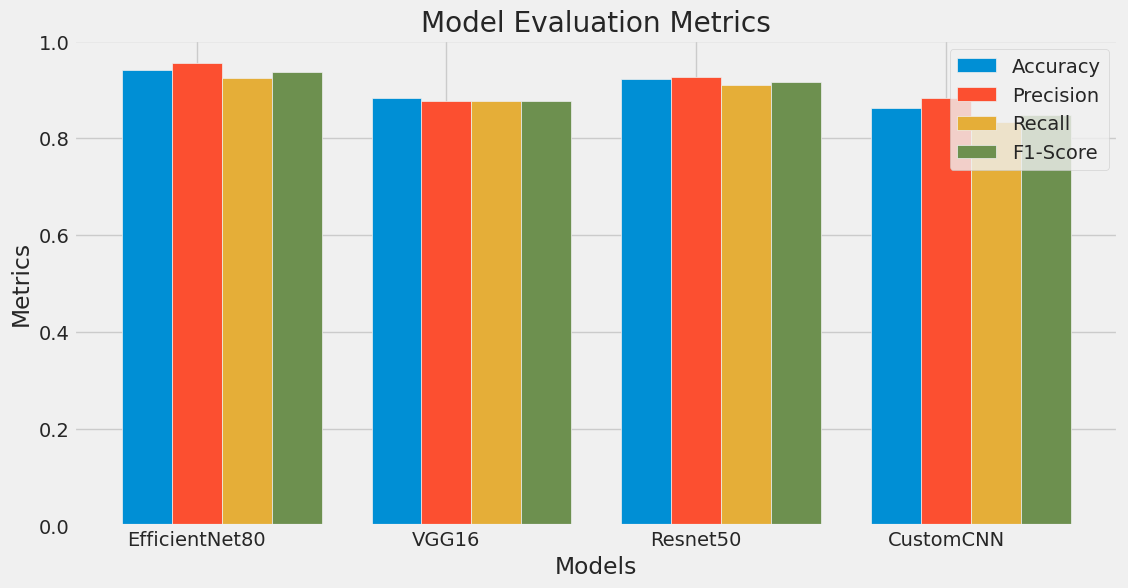

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define a list of models and their file paths (replace with your model file paths)
model_paths = {
    "EfficientNet80": "Model_effnet.h5",
    "VGG16": "Model_vgg.h5",
    "Resnet50": "Model_resnet50.h5",
    "CustomCNN": "Model_cnn.h5",
}

# Initialize a dictionary to store the evaluation metrics
metrics_dict = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []}

# Loop through each model and evaluate
for model_name, model_path in model_paths.items():
    # Load the pre-trained model
    model = load_model(model_path)

    # Evaluate the model on your test generator (replace test_gen)
    test_score = model.evaluate(test_gen, verbose=1)
    test_loss, test_accuracy = test_score

    # Predict using the model and get true labels (replace test_gen)
    y_true = test_gen.classes
    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate the classification report
    report = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)

    # Store evaluation metrics in the dictionary
    metrics_dict["Model"].append(model_name)
    metrics_dict["Accuracy"].append(test_accuracy)
    metrics_dict["Precision"].append(report["macro avg"]["precision"])
    metrics_dict["Recall"].append(report["macro avg"]["recall"])
    metrics_dict["F1-Score"].append(report["macro avg"]["f1-score"])

# Create a Pandas DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Display the table
print(metrics_df)

# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.2
x = np.arange(len(metrics_df["Model"]))  # Use metrics_df["Model"] to get the list of model names

for i, metric in enumerate(["Accuracy", "Precision", "Recall", "F1-Score"]):
    ax.bar(x + i * width, metrics_df[metric], width, label=metric)

ax.set_xlabel("Models")
ax.set_ylabel("Metrics")
ax.set_title("Model Evaluation Metrics")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics_df["Model"])  # Use metrics_df["Model"] for model labels
ax.legend()

plt.show()

